In [1]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline
#%matplotlib
from datetime import datetime


Populating the interactive namespace from numpy and matplotlib


In [2]:
filename = "shortened.csv"

#create sample dataframe 
global_temp_city  = pd.read_csv(filename).dropna()
#global_temp_city = global_temp_city.drop('Unnamed: 0', 1)   #this is here for if we used the random files that albert added on github

#format dt column to be a datetime value 
global_temp_city['dt'] =  pd.to_datetime(global_temp_city['dt'])

global_temp_city[:6]

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01 00:00:00,6.068,1.737,Århus,Denmark,57.05N,10.33E
5,1744-04-01 00:00:00,5.788,3.624,Århus,Denmark,57.05N,10.33E
6,1744-05-01 00:00:00,10.644,1.283,Århus,Denmark,57.05N,10.33E
7,1744-06-01 00:00:00,14.051,1.347,Århus,Denmark,57.05N,10.33E
8,1744-07-01 00:00:00,16.082,1.396,Århus,Denmark,57.05N,10.33E
10,1744-09-01 00:00:00,12.781,1.454,Århus,Denmark,57.05N,10.33E


In [3]:
#create new column for year and average temp for each year 
global_temp_city['year']= global_temp_city['dt'].map(lambda x: x.date().year)
global_temp_city[0:6]

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year
0,1743-11-01 00:00:00,6.068,1.737,Århus,Denmark,57.05N,10.33E,1743
5,1744-04-01 00:00:00,5.788,3.624,Århus,Denmark,57.05N,10.33E,1744
6,1744-05-01 00:00:00,10.644,1.283,Århus,Denmark,57.05N,10.33E,1744
7,1744-06-01 00:00:00,14.051,1.347,Århus,Denmark,57.05N,10.33E,1744
8,1744-07-01 00:00:00,16.082,1.396,Århus,Denmark,57.05N,10.33E,1744
10,1744-09-01 00:00:00,12.781,1.454,Århus,Denmark,57.05N,10.33E,1744


In [26]:
yearlyAvgCountryTemps = global_temp_city.groupby(['Country','year'])['AverageTemperature'].mean()


# create dataframe with info
yearlyAvgCountryTempsDF = DataFrame({'avgTemp':yearlyAvgCountryTemps.values,'temporary':yearlyAvgCountryTemps.index.values})
yearlyAvgCountryTempsDF['Country'] = yearlyAvgCountryTempsDF['temporary'].map(lambda x : x[0])
yearlyAvgCountryTempsDF['year'] = yearlyAvgCountryTempsDF['temporary'].map(lambda x : x[1])
yearlyAvgCountryTempsDF = yearlyAvgCountryTempsDF.drop('temporary', 1)   

yearlyAvgCountryTempsDF

,avgTemp,Country,year
0,15.542250,Australia,1841
1,15.614833,Australia,1842
2,15.885250,Australia,1843
3,15.256917,Australia,1844
4,15.624667,Australia,1845
5,16.115417,Australia,1846
6,15.622750,Australia,1847
7,15.307500,Australia,1848
8,15.194750,Australia,1849
9,15.679273,Australia,1850


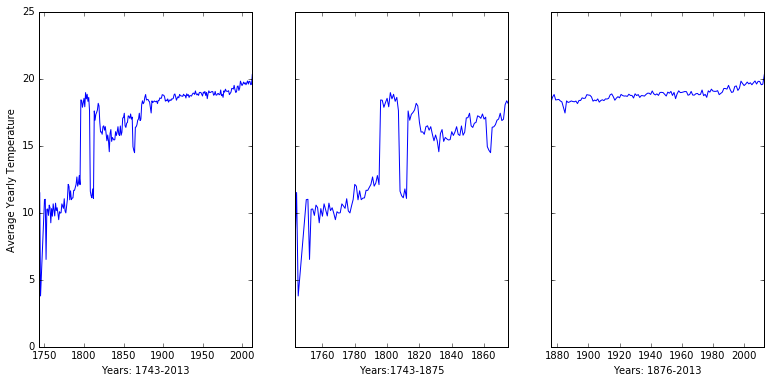

In [5]:
# average temperatures for different years
yearlyAvgTemps = global_temp_city.groupby('year')['AverageTemperature'].mean()
yearlyTempCount = global_temp_city.groupby('year')['AverageTemperature'].count()

# create dataframe with info
yearlyAvgTempsDF = DataFrame({'avgTemp':yearlyAvgTemps.values,'year':yearlyAvgTemps.index.values})


#built this subplot to look at the avg temp per year and compare two different time frames where the temperature 
#measurements seem to be wildly different. I think this has to do with thermometer technology improving over time
#first plot shows all years, second plot shows 1743-1875, third shows 1876 -2013
fig, (ax1,ax2,ax3)= subplots(nrows=1, ncols=3,sharey=True,figsize=(13,6))
yearlyAvgTemps.plot(ax=ax1)
ax1.set_ylabel('Average Yearly Temperature')
ax1.set_xlabel('Years: 1743-2013')
yearlyAvgTemps[:129].plot(ax=ax2)
ax2.set_xlabel('Years:1743-1875')
yearlyAvgTemps[129:].plot(ax=ax3)
ax3.set_xlabel('Years: 1876-2013')

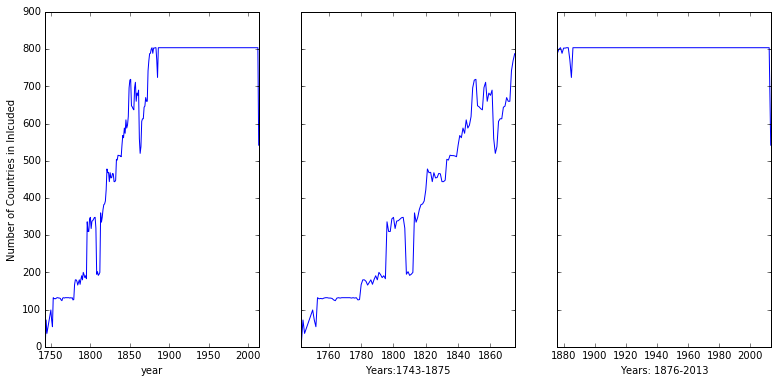

In [6]:
fig2, (ax1,ax2,ax3)= subplots(nrows=1, ncols=3,sharey=True,figsize=(13,6))
yearlyTempCount.plot(ax=ax1)
ax1.set_ylabel('Number of Countries in Inlcuded')
ax2.set_xlabel('Years: 1743-2013')
yearlyTempCount[:129].plot(ax=ax2)
ax2.set_xlabel('Years:1743-1875')
yearlyTempCount[129:].plot(ax=ax3)
ax3.set_xlabel('Years: 1876-2013')

In [7]:
#Some descriptive stats to show the differences in the time periods that we described above.
#Here we can clearly see through the STD Dev that the first time period had really spread out measurements 
#it stabilized in the second period
DF2= DataFrame()
DF2['All Years']=yearlyAvgTemps.describe()
DF2['1742-1875'] = yearlyAvgTemps[:129].describe()
DF2['1876-2013'] = yearlyAvgTemps[129:].describe()
DF2

,All Years,1742-1875,1876-2013
count,267.000000,129.000000,138.000000
mean,16.620170,14.208123,18.874909
std,3.286929,3.301486,0.440402
min,3.797611,3.797611,17.459581
25%,15.789244,11.012333,18.581008
50%,18.358076,15.632451,18.837322
75%,18.847985,16.993055,19.071381
max,20.336554,18.981166,20.336554


In [8]:
# Now i want to run a regression usuing the yearlyAvgTemps buy separating them by the time periods.

In [9]:
all_years = pd.ols(x=yearlyAvgTempsDF['year'],y=yearlyAvgTempsDF['avgTemp'])
first_group = pd.ols(x=yearlyAvgTempsDF['year'][:129],y=yearlyAvgTempsDF['avgTemp'][:129])
second_group = pd.ols(x=yearlyAvgTempsDF['year'][129:],y=yearlyAvgTempsDF['avgTemp'][129:])


In [10]:
#i printed the result and what I see is that the change over time can be better explained by the change in years
#when separated. the change in temperature  can be better explained by the increase in years after 1875.
print all_years
print first_group
print second_group


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         267
Number of Degrees of Freedom:   2

R-squared:         0.6868
Adj R-squared:     0.6856

Rmse:              1.8429

F-stat (1, 265):   581.1750, p-value:     0.0000

Degrees of Freedom: model 1, resid 265

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x     0.0352     0.0015      24.11     0.0000     0.0324     0.0381
     intercept   -49.6303     2.7504     -18.04     0.0000   -55.0211   -44.2395
---------------------------------End of Summary---------------------------------


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         129
Number

In [11]:
#a mask that filters out the years so we can filter out the old data that we decided not to use for analysis
#
year_mask = ('year'>1875)



In [12]:
# add city, country column to main DF
global_temp_city["city_country"] = global_temp_city["City"]+", "+global_temp_city['Country']


In [27]:
# merge original dataframe with yearly averages dataframe
global_temp_city_w_yrlyAvg = pd.merge(global_temp_city, yearlyAvgTempsDF,\
                          left_on = 'year', right_on = 'year',\
                           suffixes=['_alldata','avgYearTemps'])
global_temp_city_w_yrlyAvg[:10]


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,city_country,avgTemp
0,1743-11-01 00:00:00,6.068,1.737,Århus,Denmark,57.05N,10.33E,1743,"Århus, Denmark",7.399889
1,1743-11-01 00:00:00,10.013,2.291,Çorlu,Turkey,40.99N,27.69E,1743,"Çorlu, Turkey",7.399889
2,1743-11-01 00:00:00,10.779,1.942,A Coruña,Spain,42.59N,8.73W,1743,"A Coruña, Spain",7.399889
3,1743-11-01 00:00:00,6.425,1.628,Aachen,Germany,50.63N,6.34E,1743,"Aachen, Germany",7.399889
4,1743-11-01 00:00:00,6.068,1.737,Aalborg,Denmark,57.05N,10.33E,1743,"Aalborg, Denmark",7.399889
5,1743-11-01 00:00:00,8.758,1.886,Aberdeen,United Kingdom,57.05N,1.48W,1743,"Aberdeen, United Kingdom",7.399889
6,1743-11-01 00:00:00,7.478,1.866,Aix En Provence,France,44.20N,4.47E,1743,"Aix En Provence, France",7.399889
7,1743-11-01 00:00:00,3.209,1.961,Akron,United States,40.99N,80.95W,1743,"Akron, United States",7.399889
8,1743-11-01 00:00:00,7.801,2.002,Albacete,Spain,39.38N,2.08W,1743,"Albacete, Spain",7.399889
9,1744-04-01 00:00:00,5.788,3.624,Århus,Denmark,57.05N,10.33E,1744,"Århus, Denmark",11.524361


In [28]:
# average temperatures for all years for different cities
cityAvgTempsAllYrs = global_temp_city.groupby(['city_country','Latitude','Longitude'])['AverageTemperature'].mean()

#create dataframe with information (because series suck)
cityAvgTempsAllYrsDF = DataFrame({'temporary':cityAvgTempsAllYrs.index.values,\
                           'avgTemp':cityAvgTempsAllYrs.values})
cityAvgTempsAllYrsDF['city_country'] = cityAvgTempsAllYrsDF['temporary'].map(lambda x : x[0])
cityAvgTempsAllYrsDF['lat'] = cityAvgTempsAllYrsDF['temporary'].map(lambda x : x[1])
cityAvgTempsAllYrsDF['long'] = cityAvgTempsAllYrsDF['temporary'].map(lambda x : x[2])
cityAvgTempsAllYrsDF = cityAvgTempsAllYrsDF.drop('temporary', 1)          


cityAvgTempsAllYrsDF[:10]

,avgTemp,city_country,lat,long
0,13.147277,"A Coruña, Spain",42.59N,8.73W
1,8.825173,"Aachen, Germany",50.63N,6.34E
2,7.695135,"Aalborg, Denmark",57.05N,10.33E
3,26.612824,"Aba, Nigeria",5.63N,8.07E
4,25.034749,"Abadan, Iran",29.74N,48.00E
5,26.612824,"Abakaliki, Nigeria",5.63N,8.07E
6,-0.551814,"Abakan, Russia",53.84N,91.36E
7,7.261619,"Abbotsford, Canada",49.03N,122.45W
8,26.418886,"Abengourou, Côte D'Ivoire",7.23N,4.05W
9,26.373105,"Abeokuta, Nigeria",7.23N,4.05E


In [29]:
# average temperatures each year for different cities
cityAvgTempsEachYr = global_temp_city.groupby(['city_country','Latitude','Longitude','year'])['AverageTemperature'].mean()

#create dataframe with information (because series suck)
cityAvgTempsEachYrDF = DataFrame({'temporary':cityAvgTempsEachYr.index.values,\
                           'avgTemp':cityAvgTempsEachYr.values})
cityAvgTempsEachYrDF['city_country'] = cityAvgTempsEachYrDF['temporary'].map(lambda x : x[0])
cityAvgTempsEachYrDF['lat'] = cityAvgTempsEachYrDF['temporary'].map(lambda x : x[1])
cityAvgTempsEachYrDF['long'] = cityAvgTempsEachYrDF['temporary'].map(lambda x : x[2])
cityAvgTempsEachYrDF['year'] = cityAvgTempsEachYrDF['temporary'].map(lambda x : x[3])
cityAvgTempsEachYrDF = cityAvgTempsEachYrDF.drop('temporary', 1)          


print cityAvgTempsEachYrDF[:10]

     avgTemp     city_country     lat   long  year
0  10.779000  A Coruña, Spain  42.59N  8.73W  1743
1  13.678125  A Coruña, Spain  42.59N  8.73W  1744
2   9.170500  A Coruña, Spain  42.59N  8.73W  1745
3  13.489273  A Coruña, Spain  42.59N  8.73W  1750
4  13.698500  A Coruña, Spain  42.59N  8.73W  1751
5  10.771333  A Coruña, Spain  42.59N  8.73W  1752
6  13.151833  A Coruña, Spain  42.59N  8.73W  1753
7  13.221000  A Coruña, Spain  42.59N  8.73W  1754
8  12.906000  A Coruña, Spain  42.59N  8.73W  1755
9  13.255500  A Coruña, Spain  42.59N  8.73W  1756


In [30]:
# create pivottable/timeseries
date_city_pivot = pd.pivot_table(cityAvgTempsEachYrDF,\
                                index='year',\
                                columns='city_country')
date_city_pivot[90:100]

avgTemp                                                \
city_country A Coruña, Spain Aachen, Germany Aalborg, Denmark Aba, Nigeria   
year                                                                         
1837               12.837000        8.034500         6.991167          NaN   
1838               12.789000        7.395750         5.817333          NaN   
1839               12.752083        8.760500         6.954833          NaN   
1840               12.607083        7.852417         6.725417          NaN   
1841               12.778583        9.112250         7.287083          NaN   
1842               12.882750        8.530583         8.214000          NaN   
1843               13.075250        8.889417         7.830250          NaN   
1844               12.888083        7.906000         6.463000          NaN   
1845               12.470917        7.600583         6.787000          NaN   
1846               13.523667        9.806667         8.781750          NaN   

                                                             \
city_country Abadan, Iran Abakaliki, Nigeria Abakan, Russia   
year                                                          
1837                  NaN                NaN      -1.522250   
1838                  NaN                NaN      -1.885833   
1839            12.220000                NaN      -2.551083   
1840            24.195500                NaN      -1.697750   
1841            21.257333                NaN      -2.684417   
1842            23.229250                NaN      -0.244583   
1843            24.576833                NaN       0.195667   
1844            24.289750                NaN      -0.912167   
1845            24.361083                NaN      -1.094000   
1846            25.761091                NaN      -0.557333   

                                                                             \
city_country Abbotsford, Canada Abengourou, Côte D'Ivoire Abeokuta, Nigeria   
year                                                                          
1837                   6.611250                       NaN               NaN   
1838                   6.372250                       NaN               NaN   
1839                   7.119250                       NaN               NaN   
1840                   6.450333                       NaN               NaN   
1841                   6.594250                       NaN               NaN   
1842                   6.640667                       NaN               NaN   
1843                   6.254917                       NaN               NaN   
1844                   6.151917                       NaN               NaN   
1845                   6.616500                       NaN               NaN   
1846                        NaN                       NaN               NaN   

                  ...                                                        \
city_country      ...      Alagoinhas, Brazil Alandur, India Alanya, Turkey   
year              ...                                                         
1837              ...               24.096250      27.829417      17.220500   
1838              ...               24.279333      27.967750      17.106333   
1839              ...               24.300750      27.951167      17.429333   
1840              ...               24.671750      27.993417      17.322833   
1841              ...               24.477500      27.587000      18.153750   
1842              ...               24.874000      27.705250      17.737500   
1843              ...               24.997667      27.424083      17.846333   
1844              ...                     NaN      27.629167      17.657833   
1845              ...                     NaN      27.951000      18.057667   
1846              ...                     NaN      28.372167      18.586917   

                                                                            \
city_country Alappuzha, India Albacete, Spain Århus,

In [31]:
test1 = date_city_pivot - date_city_pivot.shift(1)

In [32]:
test1[:10]

avgTemp                                                \
city_country A Coruña, Spain Aachen, Germany Aalborg, Denmark Aba, Nigeria   
year                                                                         
1743                     NaN             NaN              NaN          NaN   
1744                2.899125        3.665125         2.939125          NaN   
1745               -4.507625       -7.539375        -8.980625          NaN   
1750                4.318773        7.151523         8.699045          NaN   
1751                0.209227       -0.186523        -0.679170          NaN   
1752               -2.927167       -4.240417        -3.955542          NaN   
1753                2.380500        3.507417         3.327833          NaN   
1754                0.069167       -0.330583        -0.091583          NaN   
1755               -0.315000       -0.250917        -0.244250          NaN   
1756                0.349500        0.593500         0.694000          NaN   

                                                             \
city_country Abadan, Iran Abakaliki, Nigeria Abakan, Russia   
year                                                          
1743                  NaN                NaN            NaN   
1744                  NaN                NaN            NaN   
1745                  NaN                NaN            NaN   
1750                  NaN                NaN            NaN   
1751                  NaN                NaN            NaN   
1752                  NaN                NaN            NaN   
1753                  NaN                NaN            NaN   
1754                  NaN                NaN            NaN   
1755                  NaN                NaN            NaN   
1756                  NaN                NaN            NaN   

                                                                             \
city_country Abbotsford, Canada Abengourou, Côte D'Ivoire Abeokuta, Nigeria   
year                                                                          
1743                        NaN                       NaN               NaN   
1744                        NaN                       NaN               NaN   
1745                        NaN                       NaN               NaN   
1750                        NaN                       NaN               NaN   
1751                        NaN                       NaN               NaN   
1752                        NaN                       NaN               NaN   
1753                        NaN                       NaN               NaN   
1754                        NaN                       NaN               NaN   
1755                        NaN                       NaN               NaN   
1756                        NaN                       NaN               NaN   

                  ...                                                        \
city_country      ...      Alagoinhas, Brazil Alandur, India Alanya, Turkey   
year              ...                                                         
1743              ...                     NaN            NaN            NaN   
1744              ...                     NaN            NaN            NaN   
1745              ...                     NaN            NaN            NaN   
1750              ...                     NaN            NaN            NaN   
1751              ...                     NaN            NaN            NaN   
1752              ...                     NaN            NaN            NaN   
1753              ...                     NaN            NaN            NaN   
1754              ...                     NaN            NaN            NaN   
1755              ...                     NaN            NaN            NaN   
1756              ...                     NaN            NaN            NaN   

                                                                            \
city_country Alappuzha, India Albacete, Spain Århus,

In [33]:
def regressOnYr(s):
    sDF = DataFrame({'year':s.index.values,\
                           'temps':s.values})
    result = pd.ols(x=sDF['year'],y=sDF['temps'])
    return result
    
    

In [34]:
timeOnAvgTempEachCity = date_city_pivot.apply(regressOnYr)

#change to datafram
timeOnAvgTempEachCityDF = DataFrame({'temporary':timeOnAvgTempEachCity.index.values,\
                           'regResults':timeOnAvgTempEachCity.values})
timeOnAvgTempEachCityDF['city_country'] = timeOnAvgTempEachCityDF['temporary'].map(lambda x : x[1])
timeOnAvgTempEachCityDF = timeOnAvgTempEachCityDF.drop('temporary', 1) 

#add relevant regression information to DF
timeOnAvgTempEachCityDF['slope']=timeOnAvgTempEachCityDF['regResults'].map(lambda x: x.beta['x'])
timeOnAvgTempEachCityDF['Y-intercept']=timeOnAvgTempEachCityDF['regResults'].map(lambda x: x.beta['intercept'])
timeOnAvgTempEachCityDF['R2']=timeOnAvgTempEachCityDF['regResults'].map(lambda x: x.r2)
timeOnAvgTempEachCityDF['pval']=timeOnAvgTempEachCityDF['regResults'].map(lambda x: x.p_value)

timeOnAvgTempEachCityDF[:10]


,regResults,city_country,slope,Y-intercept,R2,pval
0,\n-------------------------Summary of Regressi...,"A Coruña, Spain",0.003533,6.485449,0.190892,x 7.140240e-14 intercept 2.47345...
1,\n-------------------------Summary of Regressi...,"Aachen, Germany",0.004201,0.900689,0.138122,x 3.603535e-10 intercept 4.58387...
2,\n-------------------------Summary of Regressi...,"Aalborg, Denmark",0.004473,-0.741463,0.123617,x 3.466823e-09 intercept 5.90568...
3,\n-------------------------Summary of Regressi...,"Aba, Nigeria",0.008980,9.195386,0.562636,x 5.286647e-28 intercept 2.42996...
4,\n-------------------------Summary of Regressi...,"Abadan, Iran",0.010110,5.524804,0.146524,x 1.454853e-07 intercept 1.21623...
5,\n-------------------------Summary of Regressi...,"Abakaliki, Nigeria",0.008980,9.195386,0.562636,x 5.286647e-28 intercept 2.42996...
6,\n-------------------------Summary of Regressi...,"Abakan, Russia",0.009742,-19.222048,0.304126,x 7.872777e-17 intercept 1.39452...
7,\n-------------------------Summary of Regressi...,"Abbotsford, Canada",0.007547,-7.245882,0.269976,x 4.815332e-14 intercept 6.60095...
8,\n-------------------------Summary of Regressi...,"Abengourou, Côte D'Ivoire",0.009352,8.320591,0.654139,x 2.475112e-37 intercept 6.75732...
9,\n-------------------------Summary of Regressi...,"Abeokuta, Nigeria",0.008979,8.958110,0.512126,x 1.614620e-24 intercept 2.34340...


In [43]:
#load all indicator files  

filename = "agricultureland.csv"

#create sample dataframe 
agland  = pd.read_csv(filename).dropna()

filename = "arableland.csv"

#create sample dataframe 
arableland  = pd.read_csv(filename).dropna()

filename = "avgPrec.csv"

#create sample dataframe 
avgPrec  = pd.read_csv(filename).dropna()

filename = "CO2emissions.csv"

#create sample dataframe 
CO2  = pd.read_csv(filename).dropna()

filename = "cropProduction.csv"

#create sample dataframe 
cropProd  = pd.read_csv(filename).dropna()

filename = "foodProduction.csv"

#create sample dataframe 
foodProd  = pd.read_csv(filename).dropna()

filename = "Livestock.csv"

#create sample dataframe 
livestock  = pd.read_csv(filename).dropna()

indicatorFile = [agland,arableland,avgPrec,CO2,cropProd,foodProd,livestock]

In [44]:
# merge first two indicator tables
indicator = pd.merge(agland, arableland, left_on=['CountryName','CountryCode',\
                                                  'Year'],right_on=['CountryName',\
                                                'CountryCode','Year'])

# merge each other file in indicator list
for i in indicatorFile[2:]:
    indicator = pd.merge(indicator,i, left_on=['CountryName','CountryCode',\
                                                  'Year'],right_on=['CountryName',\
                                                'CountryCode','Year'])
indicator


,CountryName,CountryCode,Year,Agricultural land (% of land area),Arable land (% of land area),Average precipitation in depth (mm per year),CO2 emissions (kt),Crop production index (2004-2006 = 100),Food production index (2004-2006 = 100),Livestock production index (2004-2006 = 100)
0,Afghanistan,AFG,1962,57.837821,11.794259,327,689.396,68.90,54.68,44.08
1,Albania,ALB,1962,44.963504,15.912409,1485,2464.224,41.50,30.12,23.32
2,Algeria,DZA,1962,18.851764,2.645125,89,5669.182,53.26,39.81,15.21
3,Angola,AGO,1962,45.881126,2.165717,1010,1180.774,43.53,29.96,37.66
4,Antigua and Barbuda,ATG,1962,20.454545,15.909091,1030,102.676,205.73,121.33,32.15
5,Argentina,ARG,1962,49.853655,7.008466,591,53695.881,26.31,39.35,65.77
6,Australia,AUS,1962,60.357966,4.178827,534,94912.961,29.85,44.13,56.45
7,Austria,AUT,1962,48.934367,20.356018,1110,33905.082,76.49,70.30,70.79
8,"Bahamas, The",BHS,1962,0.999001,0.699301,1292,726.066,40.92,36.40,29.20
9,Bahrain,BHR,1962,10.144928,1.449275,83,1591.478,73.13,54.38,24.90


In [45]:
#merge cityAvgTempsEachYrDF with indicator table
cityDataPerYr = pd.merge(yearlyAvgCountryTempsDF, indicator, left_on=['Country','year'],right_on=['CountryName',\
                                                'Year'])

cityDataPerYr

,avgTemp,Country,year,CountryName,CountryCode,Year,Agricultural land (% of land area),Arable land (% of land area),Average precipitation in depth (mm per year),CO2 emissions (kt),Crop production index (2004-2006 = 100),Food production index (2004-2006 = 100),Livestock production index (2004-2006 = 100)
0,16.299417,Australia,1962,Australia,AUS,1962,60.357966,4.178827,534,94912.961,29.85,44.13,56.45
1,27.070583,Benin,1962,Benin,BEN,1962,12.965591,8.336289,1039,135.679,17.96,20.97,30.12
2,25.372667,Brazil,1962,Brazil,BRA,1962,18.654031,2.871452,1761,53695.881,24.67,16.20,13.93
3,7.490667,Canada,1962,Canada,CAN,1962,7.692629,4.533343,537,207185.500,37.69,41.33,47.32
4,6.379417,China,1962,China,CHN,1962,36.758714,10.896599,645,440359.029,18.93,14.10,4.90
5,7.212167,Denmark,1962,Denmark,DNK,1962,74.132641,65.447250,703,36926.690,59.93,70.49,71.37
6,11.091500,France,1962,France,FRA,1962,62.896528,35.666933,867,298706.486,81.74,77.24,69.49
7,26.230583,Ghana,1962,Ghana,GHA,1962,51.419531,7.471214,1187,1433.797,27.59,27.82,28.24
8,25.845628,India,1962,India,IND,1962,59.357794,52.704334,1083,143467.708,34.71,31.74,24.67
9,26.064833,Indonesia,1962,Indonesia,IDN,1962,21.307485,9.936133,2702,22995.757,22.73,21.66,17.65
